# SPICE Fast Astropy Fitting Example

This notebook demonstrates the new parallel fitting functionality for Astropy modeling.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import asdf
from tqdm.dask import TqdmCallback

import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()

from astropy.modeling import models as m
from astropy.nddata import StdDevUncertainty
from sunraster.instr.spice import read_spice_l2_fits
from sospice.calibrate import spice_error

from astropy.modeling.fitting_parallel import parallel_fit_dask
from astropy.modeling import fitting

In [2]:
%matplotlib widget

Load some SPICE data.

In [3]:
filename = "solo_L2_spice-n-ras_20230415T120519_V02_184549780-000.fits.gz"
window='N IV 765 ... Ne VIII 770 (Merged)'

spice = read_spice_l2_fits(filename)
spice = spice[window]

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-OBS to 60049.503702 from DATE-OBS.
Set MJD-BEG to 60049.503702 from DATE-BEG.
Set MJD-AVG to 60049.542980 from DATE-AVG.
Set MJD-END to 60049.582254 from DATE-END'. [astropy.wcs.wcs]


Update the mask and uncertainty information on the SpectrogramCube object.

In [4]:
av_cojstant_noise_level, sigmadict = spice_error(data=spice.data, header=spice.meta)
sigma = sigmadict["Total"].value
spice.mask = spice.mask | (spice.data <= 0) | np.isnan(sigma) | (sigma <= 0)
spice.uncertainty = StdDevUncertainty(sigma)

W / (nm sr m2)
Getting observation parameters from N IV 765 ... Ne VIII 770 (Merged)

Slit: 4.0 arcsec
Bin: (2, 1)
Exposure time: 30.0 s
Window width: 71.0 pix
Average wavelength: 76.661269 nm
RADCAL: 494.114878197 m2 ct nm sr / W
            


Now we crop out a small region of the raster

In [5]:
# drop leading length 1 dimension
spice = spice[0, :, 100:250, :150]
spice

SpectrogramCube
---------------
Time Period: ['2023-04-15 12:42:57.076' '2023-04-15 13:58:11.777']
Instrument axes: ['spectral' 'slit' 'slit step']
Pixel dimensions: [ 71 150 150] pix
Longitude range: [-2887.68089008 -2275.09374163] arcsec
Latitude range: [1186.03952418 1428.22620382] arcsec
Spectral range: [7.5978650e-08 7.7343888e-08] m
Data unit: W / (nm sr m2)

Now we setup an initial model

In [6]:
initial_model = (
    m.Const1D(amplitude=0.39436937 * spice.unit) +
    m.Gaussian1D(amplitude=0.26833042 * spice.unit, mean=764.43213904 * u.AA, stddev=0.47177362 * u.AA) +
    m.Gaussian1D(amplitude=0.39445746 * spice.unit, mean=769.72320986 * u.AA, stddev=0.43446076 * u.AA) +
    m.Gaussian1D(amplitude=0.01165394 * spice.unit, mean=761.28182695 * u.AA, stddev=0.1848058 * u.AA)
)
print(initial_model)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Const1D(amplitude=0.39436937 W / (nm sr m2))>

    [1]: <Gaussian1D(amplitude=0.26833042 W / (nm sr m2), mean=764.43213904 Angstrom, stddev=0.47177362 Angstrom)>

    [2]: <Gaussian1D(amplitude=0.39445746 W / (nm sr m2), mean=769.72320986 Angstrom, stddev=0.43446076 Angstrom)>

    [3]: <Gaussian1D(amplitude=0.01165394 W / (nm sr m2), mean=761.28182695 Angstrom, stddev=0.1848058 Angstrom)>
Parameters:
     amplitude_0    amplitude_1      mean_1    ...    mean_3     stddev_3
    W / (nm sr m2) W / (nm sr m2)   Angstrom   ...   Angstrom    Angstrom
    -------------- -------------- ------------ ... ------------ ---------
        0.39436937     0.26833042 764.43213904 ... 761.28182695 0.1848058


To compare our initial model to the data, we average out all the spatial locations to generate an average spectra.

In [7]:
avg_spectra = spice.rebin((1, *spice.data.shape[1:]))
avg_spectra = avg_spectra[:, 0, 0]  # drop length one dimensions
avg_spectra

SpectrogramCube
---------------
Time Period: None
Instrument axes: None
Pixel dimensions: [71] pix
Longitude range: None
Latitude range: None
Spectral range: [7.5978650e-08 7.7343888e-08] m
Data unit: W / (nm sr m2)

We can now plot the average spectra, and initial model together.

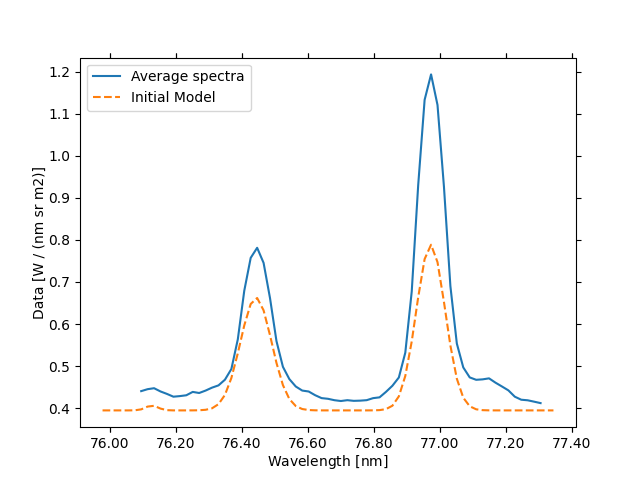

In [8]:
ax = avg_spectra.plot(axes_units=[u.nm], label="Average spectra")
ax.coords["wavelength"].set_major_formatter("x.xx")
wave = avg_spectra.axis_world_coords("em.wl")[0]
ax.plot(avg_spectra.wcs.world_to_pixel(wave), initial_model(wave), linestyle="--", label="Initial Model")
plt.legend()

## Parallel Fitting

Now we have our data and initial model we can setup a dask cluster (which is optional but nice) and then fit the model.

In [9]:
from dask.distributed import LocalCluster
cluster = LocalCluster(n_workers=os.cpu_count(), threads_per_worker=1)
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 31.27 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39811,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 31.27 GiB
Comm: tcp://127.0.0.1:34583,Total threads: 1
Dashboard: http://127.0.0.1:37143/status,Memory: 1.95 GiB
Nanny: tcp://127.0.0.1:45403,


Currently we have to extract the world coordinates due to a bug with handling of units in FITS WCS, but this should be fixed soon, and then the WCS from the spice data can be passed in.

In [10]:
wave = spice.axis_world_coords("em.wl")[0].to(u.AA)

Here we make the big call to the 

In [11]:
spice_model_fit = parallel_fit_dask(
        model=initial_model,
        fitter=fitting.TRFLSQFitter(),
        fitting_axes=0,
        data=spice.data,
        data_unit=spice.unit,
        world=(wave,),
        weights=spice.uncertainty.array,
        fitter_kwargs={"filter_non_finite": True}, # Filter out non-finite values
        chunk_n_max=np.prod(spice.data.shape[1:])/len(cluster.workers), # len(cluster.workers),  # Divide the work up equally between the workers
        scheduler="default",  # Use the cluster we created above
) 

/home/stuart/.virtualenvs/astropy-parallel-fitting/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 18.34 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Now we evaluate our fit model against the wavelength to generate a 3D array of modelled intensity for all wavelengths for the whole image.

In [12]:
all_fits = spice_model_fit(wave[:, None, None])

We can now use this to plot a comparion for one (or more) locations

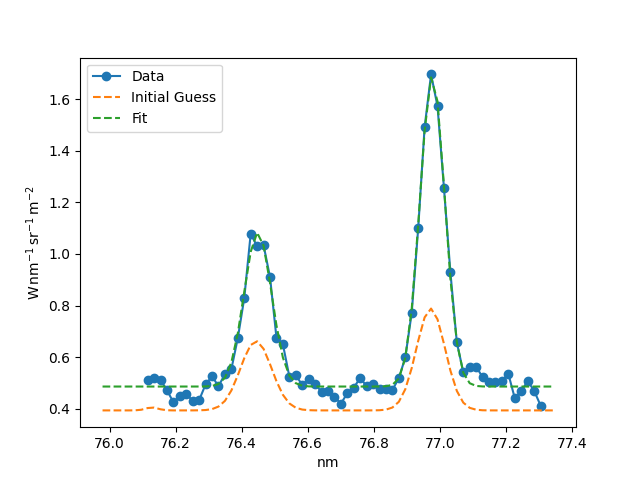

In [13]:
interesting_looking_pixel = np.s_[:, 60, 53]

fig, ax = plt.subplots()
ax.plot(wave.to(u.nm), spice.data[interesting_looking_pixel], "o-", label="Data")
ax.plot(wave, initial_model(wave), "--", label="Initial Guess")
ax.plot(wave, all_fits[interesting_looking_pixel], "--", label="Fit")
plt.legend()

Finally, let's plot a quick comparison to the initial model for all spatial locations to make sure the fit has worked.

In [14]:
shift_from_initial = spice_model_fit.mean_2.quantity - initial_model.mean_2.quantity

<WCSAxes: >

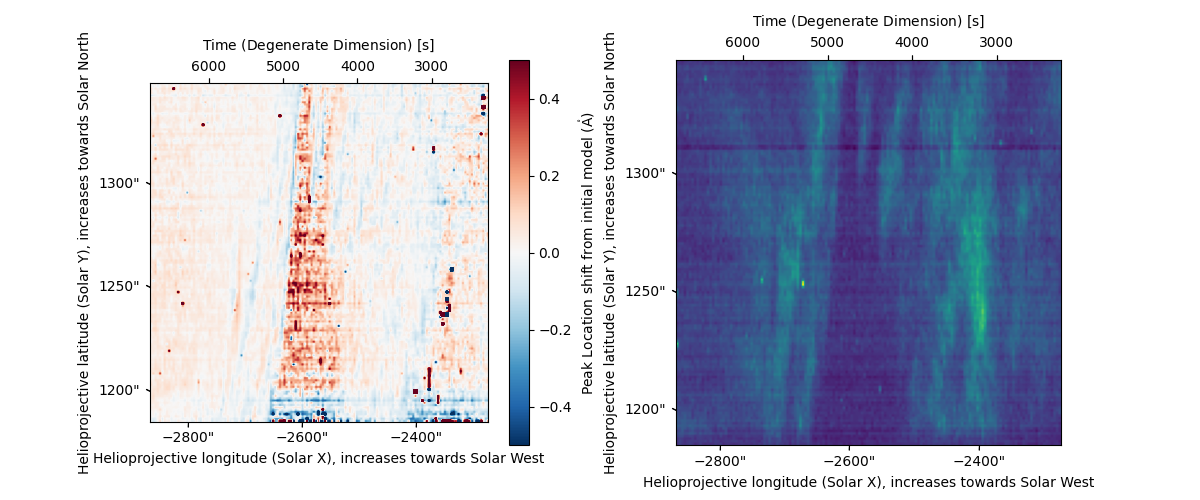

In [15]:
fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(121, projection=spice[0].wcs)
im = ax.imshow(shift_from_initial.value, cmap="RdBu_r", origin="lower", vmin=-0.5, vmax=0.5)
plt.colorbar(im, label=f"Peak Location shift from initial model ({shift_from_initial.unit:latex})")
ax = plt.subplot(122, projection=spice[60].wcs)
spice[60].plot(axes=ax)